In [11]:
from nilmtk.dataset_converters import convert_redd
convert_redd('data/REDD/low_freq', 'data/redd.h5')

Loading house 1... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 2... 1 2 3 4 5 6 7 8 9 10 11 
Loading house 3... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Loading house 4... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 5... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Loading house 6... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
Loaded metadata
Done converting YAML metadata to HDF5!
Done converting REDD to HDF5!


In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

In [2]:
rcParams['figure.figsize'] = (13, 6)

In [3]:
train = DataSet('data/redd.h5')
test = DataSet('data/redd.h5')

In [4]:
building = 1

In [23]:
train.set_window(end="2011-04-29")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


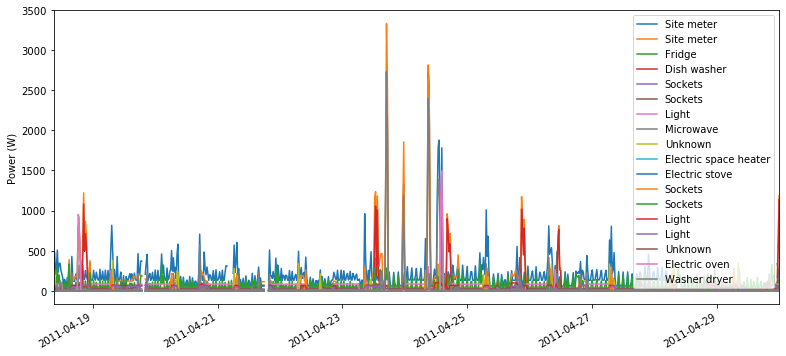

In [17]:
train_elec.plot()

In [6]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [24]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   ********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', applian

In [8]:
appliance_labels = [m.label() for m in gt.columns.values]

In [9]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

In [22]:
predictions['CO'].head(25)

,Fridge,Light,Sockets,Microwave,Dish washer,Sockets
2011-04-30 00:00:00-04:00,198.0,0.0,24.0,0.0,1069.0,21.0
2011-04-30 00:02:00-04:00,198.0,0.0,24.0,0.0,1069.0,21.0
2011-04-30 00:04:00-04:00,63.0,81.0,72.0,0.0,1069.0,21.0
2011-04-30 00:06:00-04:00,63.0,81.0,0.0,0.0,1069.0,0.0
2011-04-30 00:08:00-04:00,198.0,81.0,72.0,0.0,0.0,21.0
2011-04-30 00:10:00-04:00,0.0,0.0,0.0,401.0,0.0,0.0
2011-04-30 00:12:00-04:00,0.0,0.0,0.0,401.0,0.0,0.0
2011-04-30 00:14:00-04:00,0.0,0.0,0.0,401.0,0.0,0.0
2011-04-30 00:16:00-04:00,0.0,277.0,72.0,0.0,0.0,0.0
2011-04-30 00:18:00-04:00,0.0,277.0,72.0,0.0,0.0,0.0


In [21]:
predictions['FHMM'].head(25)

,Fridge,Light,Sockets,Microwave,Dish washer,Sockets
2011-04-30 00:00:00-04:00,6.0,81.0,22.0,1353.0,0.0,22.0
2011-04-30 00:02:00-04:00,6.0,81.0,22.0,103.0,1068.0,22.0
2011-04-30 00:04:00-04:00,6.0,81.0,22.0,103.0,1068.0,22.0
2011-04-30 00:06:00-04:00,6.0,81.0,22.0,4.0,1068.0,22.0
2011-04-30 00:08:00-04:00,169.0,81.0,41.0,4.0,48.0,22.0
2011-04-30 00:10:00-04:00,6.0,139.0,79.0,103.0,48.0,22.0
2011-04-30 00:12:00-04:00,6.0,139.0,79.0,103.0,48.0,22.0
2011-04-30 00:14:00-04:00,6.0,139.0,79.0,103.0,48.0,22.0
2011-04-30 00:16:00-04:00,6.0,139.0,79.0,103.0,0.0,22.0
2011-04-30 00:18:00-04:00,6.0,139.0,79.0,103.0,0.0,22.0


In [20]:
gt.head(25)

,Fridge,Light,Sockets,Microwave,Dish washer,Sockets
2011-04-30 00:00:00-04:00,6.000000,76.133331,30.566668,4.0,1132.033325,12.566667
2011-04-30 00:02:00-04:00,6.000000,76.206894,28.551723,4.0,1131.517212,13.965517
2011-04-30 00:04:00-04:00,6.000000,76.099998,28.233334,4.0,1132.066650,12.266666
2011-04-30 00:06:00-04:00,6.100000,76.900002,28.500000,4.0,1038.866699,14.033334
2011-04-30 00:08:00-04:00,6.612903,81.032257,24.193548,4.0,205.387100,18.967741
2011-04-30 00:10:00-04:00,6.656250,81.000000,24.281250,4.0,220.156250,20.468750
2011-04-30 00:12:00-04:00,6.843750,81.000000,24.625000,4.0,227.656250,19.875000
2011-04-30 00:14:00-04:00,6.806452,81.000000,24.096775,4.0,228.000000,19.806452
2011-04-30 00:16:00-04:00,6.843750,81.281250,24.531250,4.0,172.500000,19.656250
2011-04-30 00:18:00-04:00,6.812500,81.343750,24.031250,4.0,158.781250,20.375000


In [15]:
print(predictions['FHMM'])

                           Fridge  Light  Sockets  Microwave  Dish washer  \
2011-04-30 00:00:00-04:00     6.0   81.0     22.0     1353.0          0.0   
2011-04-30 00:02:00-04:00     6.0   81.0     22.0      103.0       1068.0   
2011-04-30 00:04:00-04:00     6.0   81.0     22.0      103.0       1068.0   
2011-04-30 00:06:00-04:00     6.0   81.0     22.0        4.0       1068.0   
2011-04-30 00:08:00-04:00   169.0   81.0     41.0        4.0         48.0   
...                           ...    ...      ...        ...          ...   
2011-05-24 14:30:00-04:00   169.0    2.0     41.0        4.0         48.0   
2011-05-24 14:32:00-04:00   169.0    2.0     41.0        4.0         48.0   
2011-05-24 14:34:00-04:00   169.0    2.0     41.0        4.0         48.0   
2011-05-24 15:54:00-04:00   169.0    2.0     41.0        4.0         48.0   
2011-05-24 15:56:00-04:00   169.0    2.0     41.0        4.0         48.0   

                           Sockets  
2011-04-30 00:00:00-04:00     22.0  
2